# Setup

**Imports**

In [6]:
#%pip install ruptures

In [5]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [7]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [35]:
signal, symbols = X_train[3], y_train[3]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

A * A 6 5 D 5 C


## Pipeline

In [19]:
import numpy as np
import ruptures as rpt
from scipy.signal import butter, lfilter, spectrogram

FS = 22050  # fréquence d'échantillonnage


4 0 B B 2 4 0 5 D 2
Nombre optimal de symboles détectés : 3


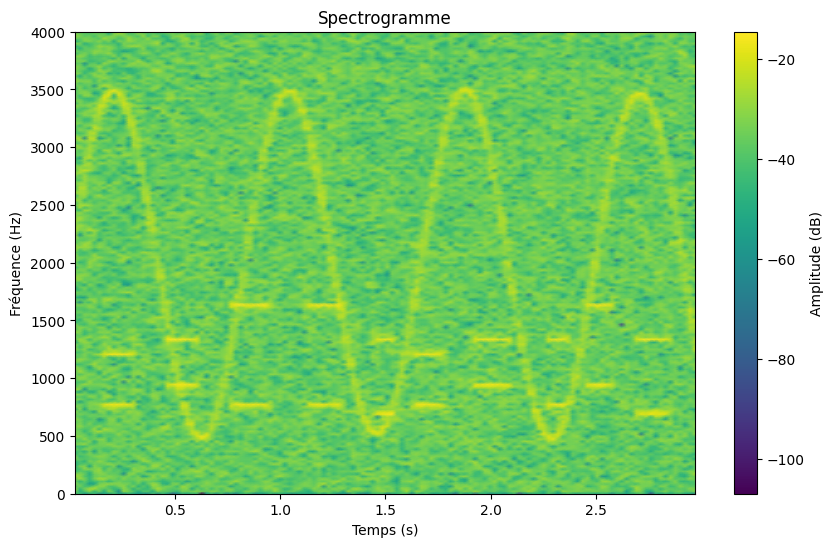

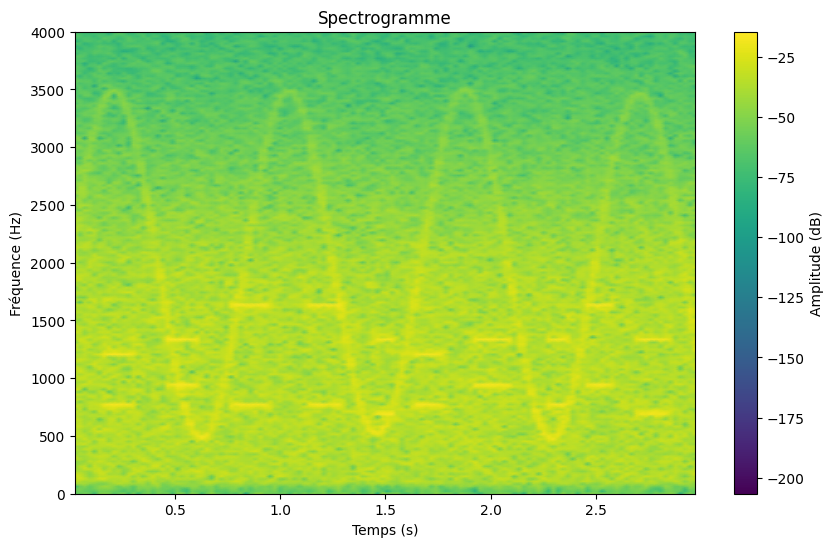

In [92]:

def reduce_noise(signal, fs, low_freq=100, high_freq=2000, order=5):
    """
    Filtre passe-bande pour conserver uniquement les fréquences DTMF.
    
    signal: ndarray
        Signal bruité d'entrée.
    fs: int
        Fréquence d'échantillonnage.
    low_freq, high_freq: float
        Limites de bande des fréquences DTMF.
    order: int
        Ordre du filtre passe-bande.
    """
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(order, [low, high], btype="band")
    return lfilter(b, a, signal)


### 2. Détection des points de rupture
def detect_change_points(signal, fs, n_bkps_max=20):
    """
    Détecte les points de rupture dans le signal à l'aide de ruptures.
    
    signal: ndarray
        Signal filtré.
    fs: int
        Fréquence d'échantillonnage.
    n_bkps_max: int
        Nombre maximum de points de rupture à détecter.
    
    Retourne:
        algo: modèle ruptures ajusté.
        costs: somme des coûts pour chaque segmentation avec 1, 2, ..., n_bkps_max ruptures.
    """
    # Spectrogramme pour une représentation temps-fréquence
    f, t, Sxx = spectrogram(signal, fs=fs)
    tempogram = Sxx.T  # Transposer pour avoir un format (temps, fréquence)

    # Modèle de détection
    algo = rpt.KernelCPD(kernel="linear").fit(tempogram)

    # Stockage des coûts pour chaque segmentation
    costs = [algo.cost.sum_of_costs(algo.predict(n_bkps=k)) for k in range(1, n_bkps_max + 1)]
    return algo, costs

def K_values(costs, max_k=20):
    """
    Affiche les coûts pour chaque valeur de k de 1 à max_k.
    
    costs: list
        Liste des coûts pour 1, 2, ..., max_k ruptures.
    max_k: int
        Nombre maximum de ruptures.
    """
    import matplotlib.pyplot as plt

    # Créer un graphique des coûts en fonction de k
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), costs, marker="o", linestyle="-", alpha=0.7)
    plt.xticks(range(1, max_k + 1))
    plt.xlabel("Nombre de ruptures (k)")
    plt.ylabel("Coût total")
    plt.title("Coûts en fonction du nombre de ruptures (k)")
    plt.grid(True)
    plt.show()


### 3. Sélection du meilleur K
def choose_optimal_k(costs):
    """
    Choisit le meilleur K en utilisant l'heuristique du "coude".
    
    costs: list
        Sommes des coûts pour 1, 2, ..., K ruptures.
    
    Retourne:
        k_opt: int
            Nombre optimal de segments.
    """
    # Calculer la variation de coûts
    deltas = np.diff(costs)
    second_deltas = np.diff(deltas)
    k_opt = np.argmax(second_deltas) + 2  # Index 1-base et +1 pour le delta
    return k_opt

# Test des fonctions
# Signal bruité (exemple)
k = 10 # indice 4, 6

test_signal, symbols = X_train[k], y_train[k]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)



# Étape 1 : Réduction de bruit
filtered_signal = reduce_noise(test_signal, fs=FS)

# Étape 2 : Détection des points de rupture
algo, costs = detect_change_points(filtered_signal, fs=FS)

# Étape 3 : Sélection du nombre optimal de symboles
optimal_k = choose_optimal_k(costs)

print(f"Nombre optimal de symboles détectés : {optimal_k}")
#K_values(costs)

# Spectrogramme brut
plot_spectrogram(test_signal, FS)

# Spectrogramme filtré
plot_spectrogram(filtered_signal, FS)


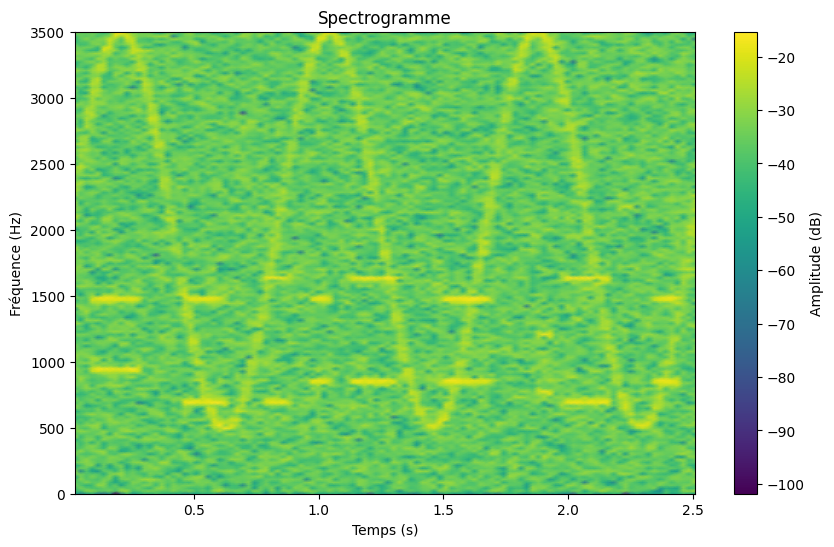

In [83]:
from scipy.signal import stft, istft
import numpy as np

def suppress_chirp(signal, fs, freq_range=(500, 3000), chirp_period=0.841):
    """
    Supprime un bruit chirp modulé dans un signal.
    
    signal: ndarray
        Signal d'entrée.
    fs: int
        Fréquence d'échantillonnage.
    freq_range: tuple
        Plage des fréquences du chirp (min, max).
    chirp_period: float
        Période de variation du chirp (en secondes).
    """
    # STFT pour analyse temps-fréquence
    f, t, Zxx = stft(signal, fs=fs, nperseg=1024, noverlap=512)

    # Construire un masque pour atténuer le chirp
    mask = np.ones_like(Zxx)
    for i, time in enumerate(t):
        # Calcul de la fréquence centrale du chirp à ce temps
        freq_chirp = freq_range[0] + (freq_range[1] - freq_range[0]) * \
                     (0.5 * (1 + np.sin(2 * np.pi * time / chirp_period)))

        # Cible les fréquences proches de freq_chirp
        mask[:, i] = np.exp(-((f - freq_chirp) ** 2) / (2 * (100 ** 2)))  # Filtre gaussien

    # Applique le masque
    Zxx_filtered = Zxx * mask

    # Reconstruction du signal après filtrage
    _, clean_signal = istft(Zxx_filtered, fs=fs)
    return clean_signal


signal_without_chirp = suppress_chirp(test_signal, FS)
filtered_signal = reduce_noise(signal_without_chirp, fs=FS)

# Visualiser le spectrogramme après suppression
#plot_spectrogram(filtered_signal, FS)


plot_spectrogram(test_signal, FS)


In [74]:
#2T = 9cm
#2s = 10.7

T = 9/10.7 
1/T
# 1s = 5.35 cm
# xx = 3.2 cm
#b = 3.2 cm
#3.2/5.35

1.1888888888888887

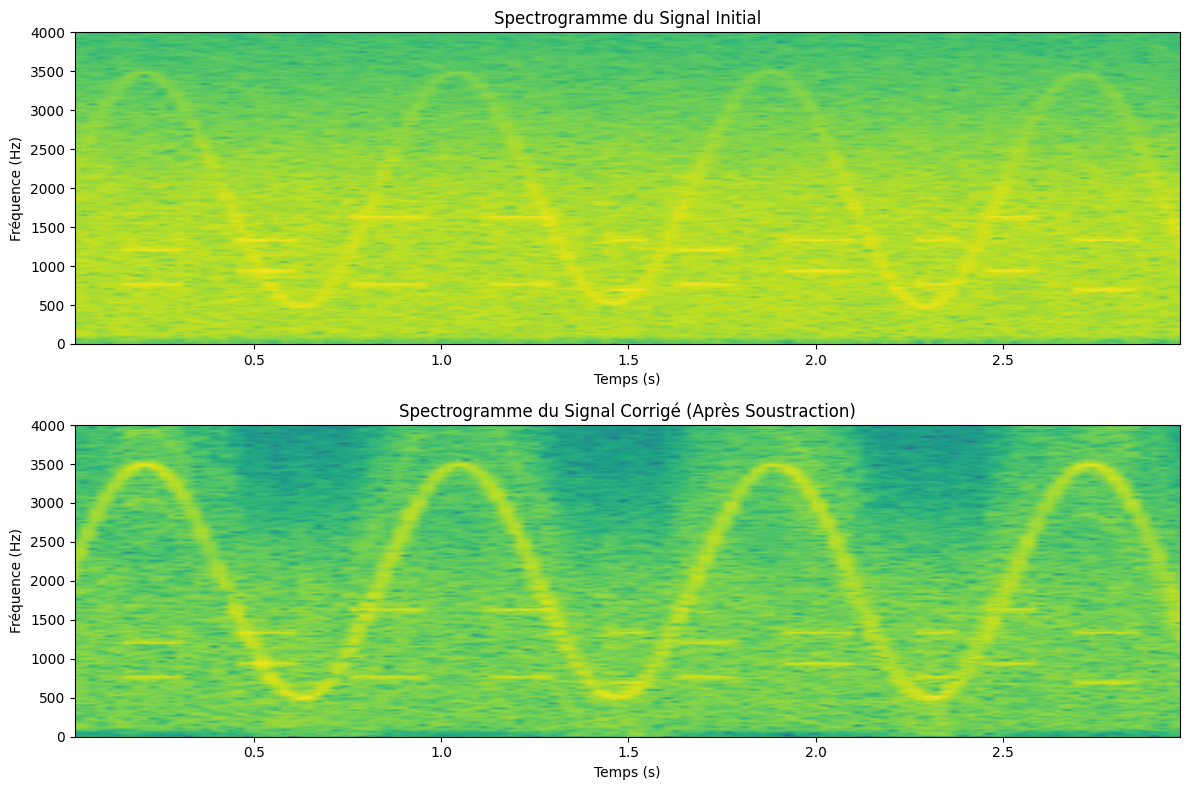

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def process_signal_with_modulated_subtraction(input_signal, fs=FS, f_min=500, f_max=3500, f_mod=1.19, initial_phase=2*np.pi*2200):
    """
    Soustrait un signal modulé périodiquement à un signal d'entrée, 
    et affiche les spectrogrammes du signal initial et du signal corrigé.
    
    Parameters:
    - input_signal (numpy array): Le signal d'entrée à traiter.
    - fs (int): Fréquence d'échantillonnage (Hz).
    - f_min (float): Fréquence minimale de modulation (Hz).
    - f_max (float): Fréquence maximale de modulation (Hz).
    - f_mod (float): Fréquence de modulation périodique (Hz).
    - initial_phase (float): Phase initiale du signal modulé (en radians).
    """
    # Calculer la durée du signal en fonction de sa longueur
    T = len(input_signal) / fs
    
    # Calculer les paramètres de la modulation
    f_center = (f_max + f_min) / 2  # Fréquence centrale
    f_deviation = (f_max - f_min) / 2  # Amplitude de modulation
    
    # Générer l'axe temporel
    t = np.linspace(0, T, len(input_signal), endpoint=False)
    
    # Générer le signal de fréquence modulée
    modulation = np.sin(2 * np.pi * f_mod * t)  # Signal de modulation (sinusoïdal)
    instantaneous_frequency = f_center + f_deviation * modulation  # Fréquence instantanée
    modulated_signal = np.sin(2 * np.pi * np.cumsum(instantaneous_frequency) / fs + initial_phase)

    # Estimer l'amplitude moyenne ou instantanée
    from scipy.signal import hilbert
    amplitude = np.abs(hilbert(input_signal))  # Enveloppe instantanée
    modulated_signal *= amplitude

    
    # Soustraire le signal modulé du signal d'entrée
    corrected_signal = input_signal - modulated_signal
    
    # Calcul et affichage des spectrogrammes
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Spectrogramme du signal initial
    frequencies, times, Sxx = spectrogram(input_signal, fs=fs, nperseg=1024, noverlap=512)
    axes[0].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    axes[0].set_title("Spectrogramme du Signal Initial")
    axes[0].set_xlabel("Temps (s)")
    axes[0].set_ylabel("Fréquence (Hz)")
    axes[0].set_ylim(0, 4000)
    #axes[0].colorbar = plt.colorbar(ax=axes[0], label='Amplitude (dB)')
    
    # Spectrogramme du signal corrigé
    frequencies, times, Sxx = spectrogram(corrected_signal, fs=fs, nperseg=1024, noverlap=512)
    axes[1].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    axes[1].set_title("Spectrogramme du Signal Corrigé (Après Soustraction)")
    axes[1].set_xlabel("Temps (s)")
    axes[1].set_ylabel("Fréquence (Hz)")
    axes[1].set_ylim(0, 4000)
    #axes[1].colorbar = plt.colorbar(ax=axes[1], label='Amplitude (dB)')
    
    plt.tight_layout()
    plt.show()
    
    return corrected_signal

filtered_signal = reduce_noise(test_signal, fs=FS)
corrected_signal = process_signal_with_modulated_subtraction(filtered_signal)


# 3 A 9 C 9 4 A 9


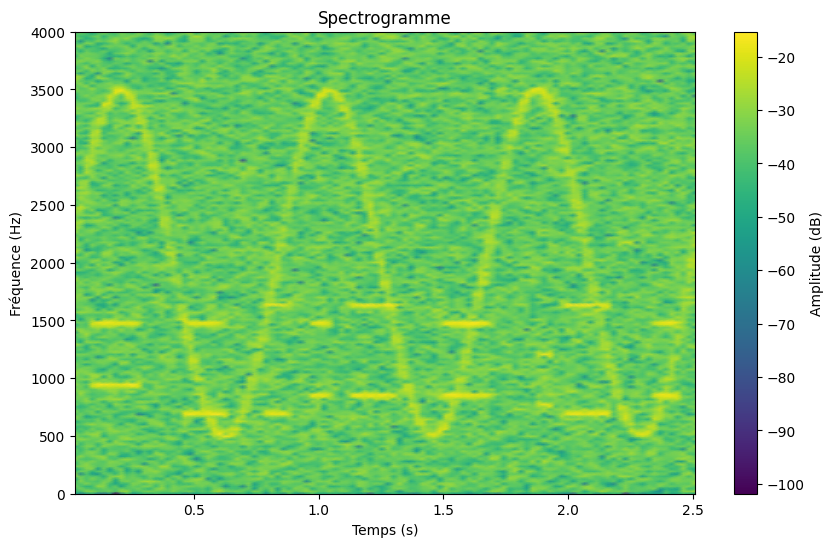

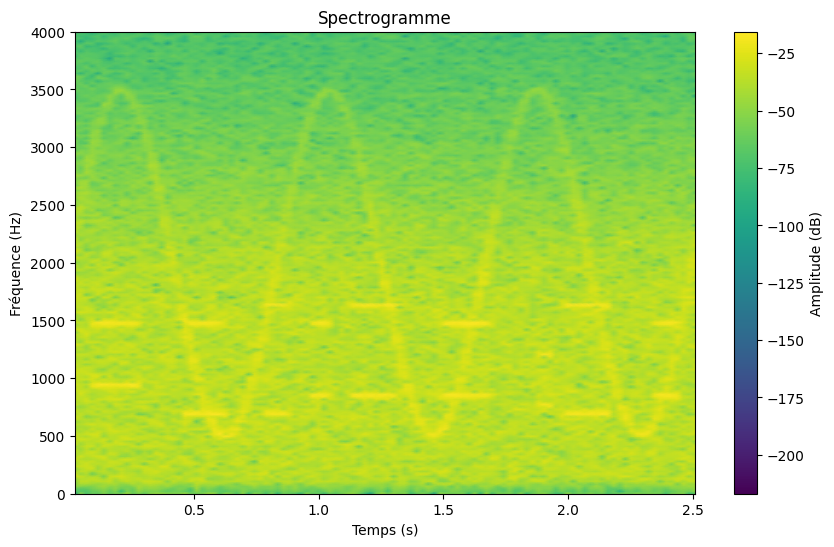

In [85]:
def plot_spectrogram(signal, fs):
    """
    Affiche le spectrogramme d'un signal.
    
    signal: ndarray
        Signal d'entrée.
    fs: int
        Fréquence d'échantillonnage.
    """
    from scipy.signal import spectrogram
    import matplotlib.pyplot as plt
    
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=1024, noverlap=512)
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud")
    plt.title("Spectrogramme")
    plt.ylabel("Fréquence (Hz)")
    plt.xlabel("Temps (s)")
    plt.colorbar(label="Amplitude (dB)")
    plt.ylim(0, 4000)  # Limiter à 2000 Hz pour le DTMF
    plt.show()

# Exemple d'appel :

print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

# Spectrogramme brut
plot_spectrogram(test_signal, FS)

# Spectrogramme filtré
filtered_signal = reduce_noise(test_signal, FS)
plot_spectrogram(filtered_signal, FS)


# Question 2

In [9]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

# Question 4

# Question 5

# Question 6

# Question 7